# Predicting Multi-MNIST digits.

Cristian Piacente 866020 \
Advanced Machine Learning course \
Master's degree in Computer Science @ University of Milan - Bicocca \
A.Y. 2024-25

The assignment consists of three tasks:

1. A multi-class classification problem: the prediction of grayscale images of double-digit numbers from a custom version of the (Multi-)MNIST dataset.

2. Unsupervised problem: the implementation of an AutoEncoder model for the encoding and reconstruction of the provided data.

3. You can choose between (one of them is mandatory, you can choose which one to do):

*   Use latent representation of autoencoder as a feature reduction
*   Explain Neural Network predictions


The dataset is created by simply concatenating pairs of MNIST digits, and the number of classes (originally all the numbers in the [0, 100] range) has been reduced.

An example of the provided dataset is the following:

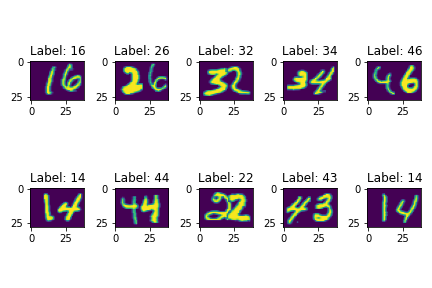

The provided data comprises the training set that can be used for the training (and for the validation) and the test set.

**General considerations**

Always describe and give proper motivations about the choices made during the assignment, including (but not limited to)

- data processing,
- network design: including number and dimension of the layers, regularization techniques (when requested).
- optimization algorithms, including hyperameters and criterions,
- model training hyperparameters
- loss/metric curves
- final evaluations and comparisons.


**Note**: Make sure that the outputs in the notebook cells are still visible once the notebook is exported (especially for html embeddings)

**Note**: Make sure that the submitted *.zip archives are not corrupted.

**Note**: convolutional layers should not be used all over this notebook (with the exception of the optional part).

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Inspecting the data

In this section we will load the data, plot both the pixel values distribution and the labels distribution, and also show a few examples.

## Load the data

In [2]:
# Load the dataset
X_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [3]:
# Shape of the training data
X_train.shape

(72247, 28, 39)

We have 72247 train images, each one with dimension 28x39.

In [4]:
# Shape of the training labels, to be sure
y_train.shape

(72247,)

In [5]:
# Preview of the labels
y_train

array([28,  9, 27, ..., 20, 29, 21], dtype=int64)

In [6]:
# Shape of the test data
X_test.shape

(24083, 28, 39)

We have 24083 test images; as before, the dimension of each one is 28x39.

In [7]:
# Shape of the test labels, to be sure
y_test.shape

(24083,)

In [8]:
# Preview of the labels
y_test

array([ 7,  9,  8, ..., 49, 20, 31], dtype=int64)

Now let's check the distribution of the labels.

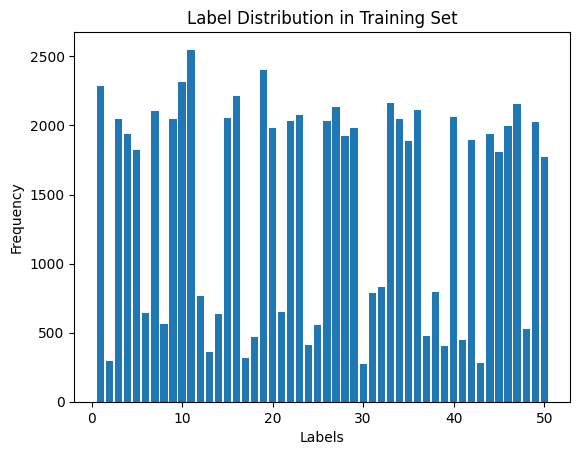

In [9]:
# Distribution of the training labels
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Label Distribution in Training Set')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

In [10]:
unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [11]:
print(f'Number of categories: {len(set(y_train))}')

Number of categories: 50


We can see no example has label 0 and the labels go from 1 to 50.

Let's make sure the same happens on the test data.

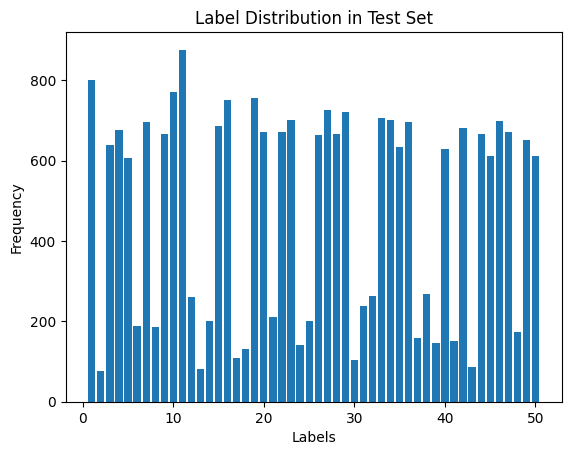

In [12]:
# Distribution of the test labels
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts)
plt.title('Label Distribution in Test Set')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

In [13]:
unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [14]:
print(f'Number of categories: {len(set(y_test))}')

Number of categories: 50


We confirmed that also the test data has labels from 1 to 50.

Let's also see the distribution of the pixel values in the training set and the test set.

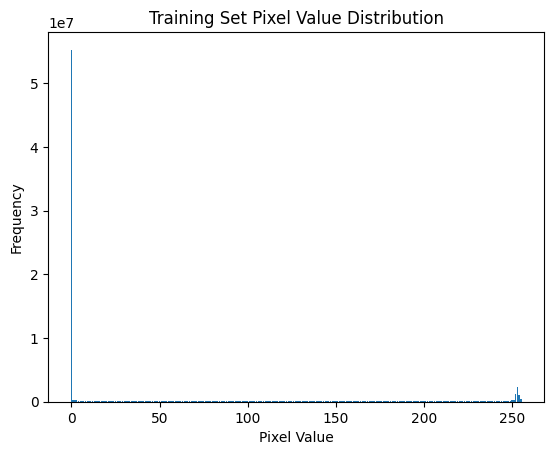

In [16]:
# Distribution of the training set
unique, counts = np.unique(X_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Training Set Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [17]:
unique

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

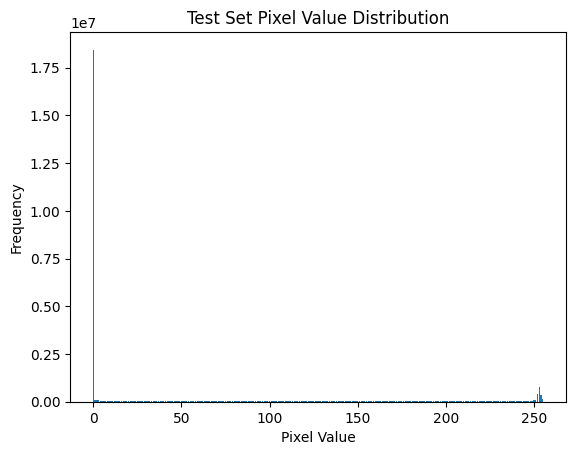

In [18]:
# Distribution of the test set
unique, counts = np.unique(X_test, return_counts=True)
plt.bar(unique, counts)
plt.title('Test Set Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [19]:
unique

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

It's not really meaningful: let's apply the logarithm on the y axis (semilog plot).

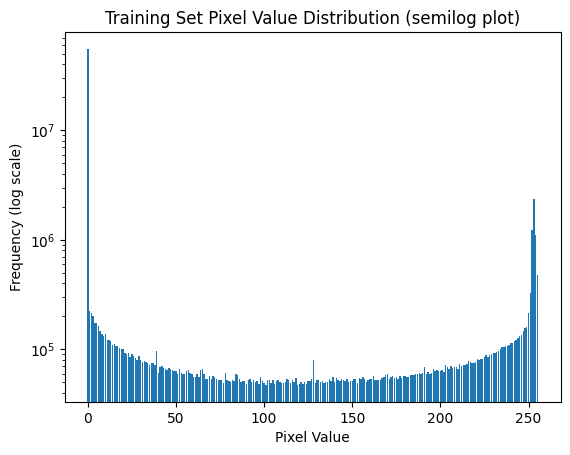

In [20]:
# Distribution of the training set (semilog plot)
unique, counts = np.unique(X_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Training Set Pixel Value Distribution (semilog plot)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.show()

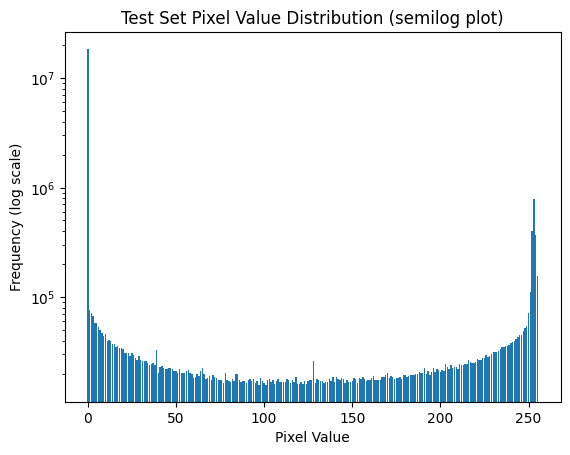

In [21]:
# Distribution of the test set (semilog plot)
unique, counts = np.unique(X_test, return_counts=True)
plt.bar(unique, counts)
plt.title('Test Set Pixel Value Distribution (semilog plot)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.show()

We can see the most frequent pixel values are the minimum, that is 0, and the maximum (or a value near it), that is 255, as seen before; let's confirm that these are the min and the max values.

In [22]:
print(f"Min value in training set: {np.min(X_train)}")
print(f"Max value in training set: {np.max(X_train)}")

print(f"Min value in test set: {np.min(X_test)}")
print(f"Max value in test set: {np.max(X_test)}")

Min value in training set: 0
Max value in training set: 255
Min value in test set: 0
Max value in test set: 255


Finally, let's see the first 5 example images, to get a preview:

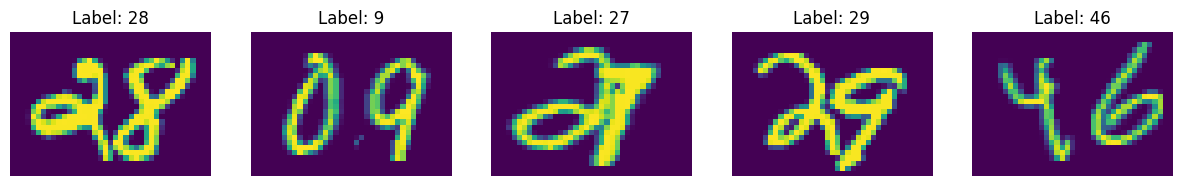

In [15]:
# Plot a few examples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

# Preparing the data

In this section we will perform the preprocessing operations on the data, according to what we saw before during the the data inspection, needed before implementing the models.

Let's reshape data to be in vectorial form (the original data are images).

In [3]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

X_train.shape

(72247, 1092)

In [4]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

X_test.shape

(24083, 1092)

Now, let's normalize the data.

Since the maximum value is 255, we'll divide by it.

In [5]:
# Normalize, [0, 255] integers -> [0, 1] float
X_train = X_train / 255.0
X_test = X_test / 255.0

Let's turn the labels into categorical data by applying one-hot encoding, needed for the model's loss function.

In [6]:
# Map the labels [1, 50] integers -> [0, 49] integers
y_train -= 1
y_test -= 1

# Apply one hot encoding with 50 classes
y_train = to_categorical(y_train, num_classes=50)
y_test = to_categorical(y_test, num_classes=50)

Let's confirm that it worked.

In [27]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Before building the models, let's also split into training and validation.

In [7]:
# Training - validation set split (75-25%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

# 1. The resolution of the problem of supervised classification with traditional fully-connected neural networks. [Mandatory]

We will implement 4 models and then analyze and compare the performance: 
- Non-regularized Model
- L1 Regularized Model
- L2 Regularized Model
- Dropout Model


## Common for all models

In [8]:
# The input dimension is an image's dimension (1092) and the number of classes is 50
input_dim = X_train.shape[1]
n_classes = y_train.shape[1]
print(f"Input dimension for all the models: {input_dim}")
print(f"Number of classes: {n_classes}")

Input dimension for all the models: 1092
Number of classes: 50


In [9]:
# Functions to plot loss and accuracy curves, useful for later

def plot_loss(history, title="Loss"):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history, title="Accuracy"):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

## 1.1 Non-regularized Model

In this section, we attempt to solve the classification task with the implementation and training of a standard fully-connected Neural Network, without the use of any specific regularization technique.

### 1.1.1 Building the network

For the Non-regularized Model, we'll use a fully-connected Neural Network with **4** hidden layers, respectively with **1024, 512, 32, 16 units** and we'll use **ReLU for all hidden layers** as it's computationally efficient.

Since it's a multi-class classification, for the output layer we'll have 50 units (= number of categories) and the **Softmax** activation function, optimal for outputting probabilities in multi-classification tasks. We'll use **Categorical Cross-Entropy** as the loss function, ideal for multi-class classification.

About the optimizer, we'll use **Adam**, which is robust and helps manage gradient issues that could arise. 
We'll use a **learning rate of 0.001**, which is commonly used to balance convergence speed and stability.

The model does not include regularization at this point, which could make it prone to overfitting, particularly given the number of units in the hidden layers. However, this configuration serves as a baseline to understand how the model performs without any regularization.

In [32]:
# Non-regularized Model
model_non_regularized = Sequential()
model_non_regularized.add(Input((input_dim,)))
model_non_regularized.add(Dense(1024, activation = "relu"))
model_non_regularized.add(Dense(512, activation = "relu"))
model_non_regularized.add(Dense(32, activation = "relu"))
model_non_regularized.add(Dense(16, activation = "relu"))
model_non_regularized.add(Dense(n_classes, activation = "softmax"))

# Compile the model
model_non_regularized.compile(optimizer=Adam(learning_rate=0.001), 
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Summary of the model
model_non_regularized.summary()

# Fit the model
history_non_regularized = model_non_regularized.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=30, 
    validation_data=(X_val, y_val)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     1,119,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,826 (6.34 MB)

 Trainable params: 1,661,826 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.4216 - loss: 2.2394 - val_accuracy: 0.8371 - val_loss: 0.5842
Epoch 2/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8710 - loss: 0.4515 - val_accuracy: 0.8811 - val_loss: 0.4144
Epoch 3/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9236 - loss: 0.2555 - val_accuracy: 0.9038 - val_loss: 0.3331
Epoch 4/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9467 - loss: 0.1722 - val_accuracy: 0.9186 - val_loss: 0.2844
Epoch 5/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9635 - loss: 0.1132 - val_accuracy: 0.9277 - val_loss: 0.2622
Epoch 6/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9746 - loss: 0.0791 - val_accuracy: 0.9292 - val_loss: 0.2677
Epoch 7/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9776 - loss: 0.0690 - val_accuracy: 0.9281 - val_loss: 0.2797
Epoch 8/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9827 - loss: 0.0524 - 

In [33]:
# Make predictions on the training data
y_pred_non_regularized = model_non_regularized.predict(X_train)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_non_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_non_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_non_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_non_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_non_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the training accuracy
model_non_regularized_accuracy = accuracy_score(y_train, y_pred_non_regularized)

# Display the result
print("(Non-regularized Model) Training accuracy:", model_non_regularized_accuracy)

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
(Non-regularized Model) Training accuracy: 0.994481867675556


### 1.1.2 Analyze and comment the training results

Now that we have trained our Non-regularized Neural Network and we've got predictions on the training, let's analyze the accuracy and loss curves, as well as the training accuracy. 

Knowing the following images represent the different scenarios we can have, we can plot the learning curves and then make some considerations.

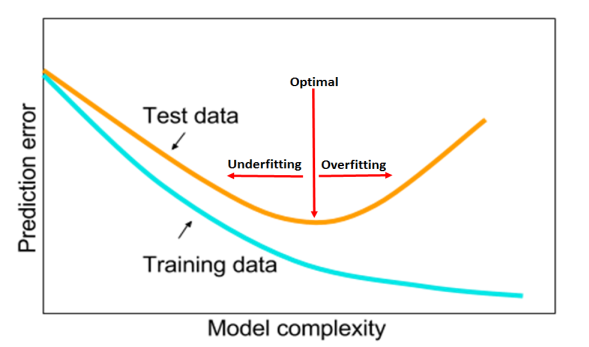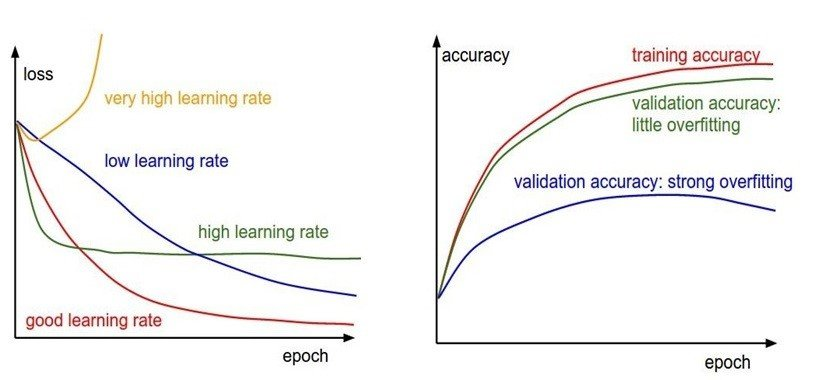

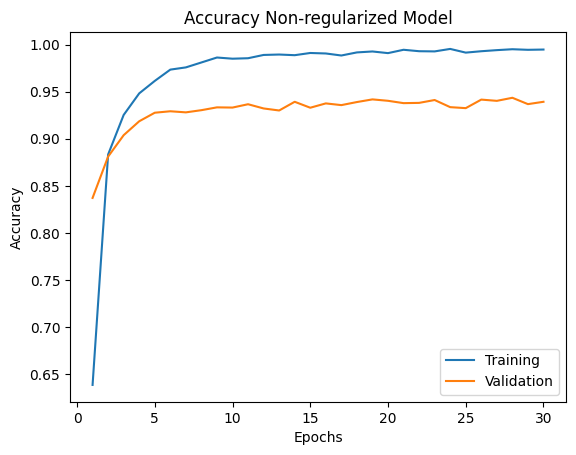

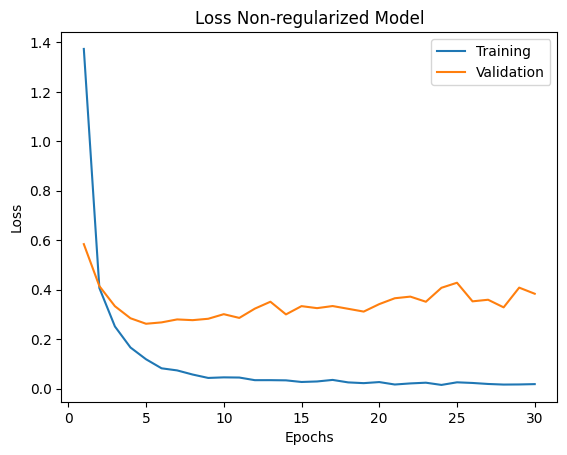

In [34]:
# Non-regularized Model
plot_accuracy(history_non_regularized, "Accuracy Non-regularized Model")
plot_loss(history_non_regularized, "Loss Non-regularized Model")

For the Non-regularized Model, the training accuracy is very high at 99.4%, meaning the model learned the training data really well. 

However, the learning curves show us a clear sign of overfitting. 

We can see that the training accuracy curve keeps improving, but the validation accuracy does not improve much after a point. 
Similarly, the training loss keeps getting smaller, but the validation loss stays steady and even increases a bit, which shows the model is struggling on new data.

The learning rate looks good because both the training and validation losses decrease steadily without jumping around. 

### 1.1.3 Validate the model and comment the results

Let's calculate the accuracy on the validation set, compare it with the training accuracy and include the previous comments about the generalization capability.

In [35]:
# Make predictions on the validation data
y_pred_val_non_regularized = model_non_regularized.predict(X_val)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_val_non_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_val_non_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_val_non_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_val_non_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_val_non_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the validation accuracy
model_non_regularized_val_accuracy = accuracy_score(y_val, y_pred_val_non_regularized)

# Display the result
print("(Non-regularized Model) Validation accuracy:", model_non_regularized_val_accuracy)

565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
(Non-regularized Model) Validation accuracy: 0.9393201195880855


The validation accuracy for the Non-regularized Model is 93.9%, which is significantly lower compared to the training accuracy of 99.4%. 

This gap between training and validation accuracies further confirms the overfitting issue previously mentioned. 

The model performs very well on training data, but struggles to generalize to new data. 
This suggests that the model has memorized the training data rather than learning patterns that generalize well to unseen examples.

To address this, regularization techniques could help improve the model's generalization capability.

## 1.2 Regularized Models

We will keep the same model architecture among all the models, to compare the performance (on training and validation here, while on the test set in section 1.3).

Also, we will keep using the same training-validation split for a better comparison.

### 1.2.1 L1 Regularized Model

For the L1 Regularized Model, we kept the same architecture as the Non-regularized Model but added L1 regularization to all hidden layers. 
This regularization penalizes large weights and encourages sparsity, effectively reducing the number of active features.

However, for the multi-MNIST dataset, **limiting active features might not be ideal** since the model benefits from capturing many complex relationships: we don't expect L1 regularization to improve performance and it may limit the model's ability to generalize well.

#### 1.2.1.1 Building the network

In [36]:
# L1 Regularized Model
model_L1_regularized = Sequential()
model_L1_regularized.add(Input((input_dim,)))
model_L1_regularized.add(Dense(1024, activation = "relu", kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
model_L1_regularized.add(Dense(512, activation = "relu", kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
model_L1_regularized.add(Dense(32, activation = "relu", kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
model_L1_regularized.add(Dense(16, activation = "relu", kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
model_L1_regularized.add(Dense(n_classes, activation = "softmax"))

# Compile the model
model_L1_regularized.compile(optimizer=Adam(learning_rate=0.001), 
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Summary of the model
model_L1_regularized.summary()

# Fit the model
history_L1_regularized = model_L1_regularized.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=30, 
    validation_data=(X_val, y_val)
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1024)           │     1,119,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,826 (6.34 MB)

 Trainable params: 1,661,826 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.0280 - loss: 91.3265 - val_accuracy: 0.0346 - val_loss: 5.8277
Epoch 2/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.0351 - loss: 5.8027 - val_accuracy: 0.0346 - val_loss: 5.8125
Epoch 3/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0362 - loss: 5.7993 - val_accuracy: 0.0346 - val_loss: 5.8067
Epoch 4/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.0368 - loss: 5.7939 - val_accuracy: 0.0346 - val_loss: 5.7843
Epoch 5/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.0352 - loss: 5.7963 - val_accuracy: 0.0346 - val_loss: 5.7786
Epoch 6/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.0370 - loss: 5.7933 - val_accuracy: 0.0346 - val_loss: 5.7982
Epoch 7/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.0369 - loss: 5.7930 - val_accuracy: 0.0346 - val_loss: 5.7907
Epoch 8/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.0349 - loss: 5.7941 -

In [37]:
# Make predictions on the training data
y_pred_L1_regularized = model_L1_regularized.predict(X_train)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_L1_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_L1_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_L1_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_L1_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_L1_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the training accuracy
model_L1_regularized_accuracy = accuracy_score(y_train, y_pred_L1_regularized)

# Display the result
print("(L1 Regularized Model) Training accuracy:", model_L1_regularized_accuracy)

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
(L1 Regularized Model) Training accuracy: 0.03548952662175879


#### 1.2.1.2 Analyze and comment the training results

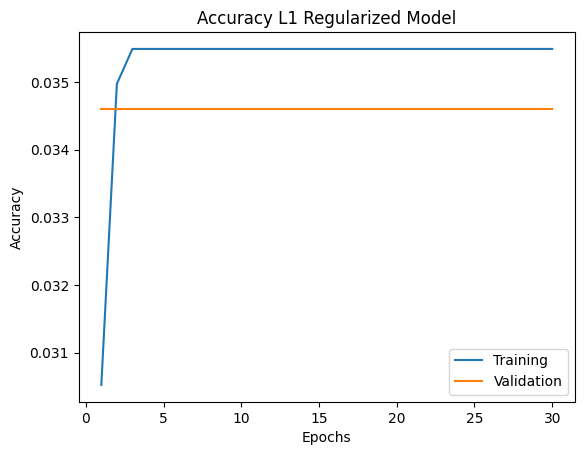

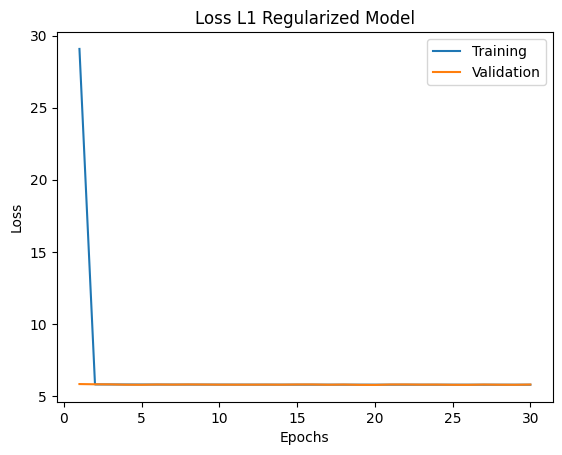

In [38]:
# L1 Regularized Model
plot_accuracy(history_L1_regularized, "Accuracy L1 Regularized Model")
plot_loss(history_L1_regularized, "Loss L1 Regularized Model")

The training results for the L1 Regularized Model are poor, with the training accuracy reaching only 3.5%, suggesting the model struggles to learn even the training data.

From the learning curves, the accuracy stays very low and does not improve over the epochs. Both the training and validation losses remain high and barely change, indicating that the model is unable to effectively learn features from the dataset.

These results align with our expectations, as L1 regularization restricts the number of active features, which limits the model's ability to capture the complex relationships necessary for the multi-MNIST dataset.

#### 1.2.1.3 Validate the model and comment the results

In [39]:
# Make predictions on the validation data
y_pred_val_L1_regularized = model_L1_regularized.predict(X_val)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_val_L1_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_val_L1_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_val_L1_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_val_L1_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_val_L1_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the validation accuracy
model_L1_regularized_val_accuracy = accuracy_score(y_val, y_pred_val_L1_regularized)

# Display the result
print("(L1 Regularized Model) Validation accuracy:", model_L1_regularized_val_accuracy)

565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
(L1 Regularized Model) Validation accuracy: 0.03460303399402059


The validation accuracy for the L1 Regularized Model is 3.46%, which is almost identical to the training accuracy of 3.5%.

Given that both accuracies are extremely low and the learning curves are flat, we can't conclude much about the model's generalization capability.

The model failed to learn from the training data effectively, and as a result, it also performed poorly on the validation set. This further confirms that L1 regularization was not suitable for this task, as it overly restricted the model's ability to learn meaningful features.

### 1.2.2 L2 Regularized Model

For the L2 Regularized Model, we retained the same architecture as the previous models, adding L2 regularization to all hidden layers. L2 regularization works by penalizing large weights, thereby encouraging the model to keep them smaller and more stable, which can help reduce overfitting.

In contrast to L1, L2 regularization does not encourage sparsity but rather encourages the model to distribute the weights more evenly. This might be more suitable for the multi-MNIST dataset, which requires recognizing complex and overlapping features in the images.

#### 1.2.2.1 Building the network

In [41]:
# L2 Regularized Model
model_L2_regularized = Sequential()
model_L2_regularized.add(Input((input_dim,)))
model_L2_regularized.add(Dense(1024, activation = "relu", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_L2_regularized.add(Dense(512, activation = "relu", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_L2_regularized.add(Dense(32, activation = "relu", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_L2_regularized.add(Dense(16, activation = "relu", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_L2_regularized.add(Dense(n_classes, activation = "softmax"))

# Compile the model
model_L2_regularized.compile(optimizer=Adam(learning_rate=0.001), 
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Summary of the model
model_L2_regularized.summary()

# Fit the model
history_L2_regularized = model_L2_regularized.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=30, 
    validation_data=(X_val, y_val)
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 1024)           │     1,119,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 50)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,826 (6.34 MB)

 Trainable params: 1,661,826 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.2876 - loss: 6.3040 - val_accuracy: 0.6576 - val_loss: 2.0350
Epoch 2/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.6775 - loss: 1.9691 - val_accuracy: 0.7172 - val_loss: 1.8133
Epoch 3/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7433 - loss: 1.7338 - val_accuracy: 0.7597 - val_loss: 1.6258
Epoch 4/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7769 - loss: 1.6023 - val_accuracy: 0.7960 - val_loss: 1.5484
Epoch 5/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7995 - loss: 1.5063 - val_accuracy: 0.7880 - val_loss: 1.5148
Epoch 6/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.8148 - loss: 1.4389 - val_accuracy: 0.8274 - val_loss: 1.3982
Epoch 7/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.8262 - loss: 1.3862 - val_accuracy: 0.8305 - val_loss: 1.3660
Epoch 8/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.8360 - loss: 1.3419 - 

In [42]:
# Make predictions on the training data
y_pred_L2_regularized = model_L2_regularized.predict(X_train)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_L2_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_L2_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_L2_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_L2_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_L2_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the training accuracy
model_L2_regularized_accuracy = accuracy_score(y_train, y_pred_L2_regularized)

# Display the result
print("(L2 Regularized Model) Training accuracy:", model_L2_regularized_accuracy)

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
(L2 Regularized Model) Training accuracy: 0.8887145889083695


#### 1.2.2.2 Analyze and comment the training results

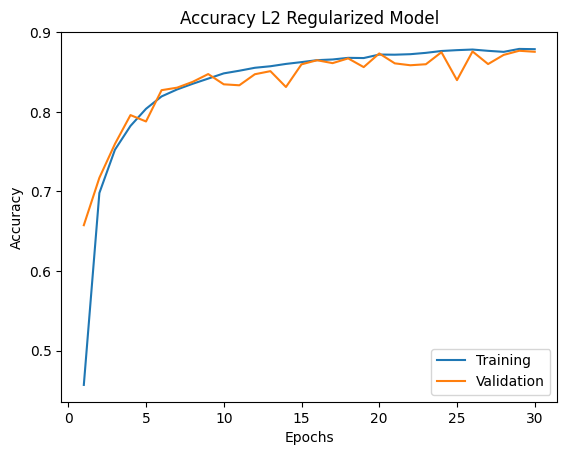

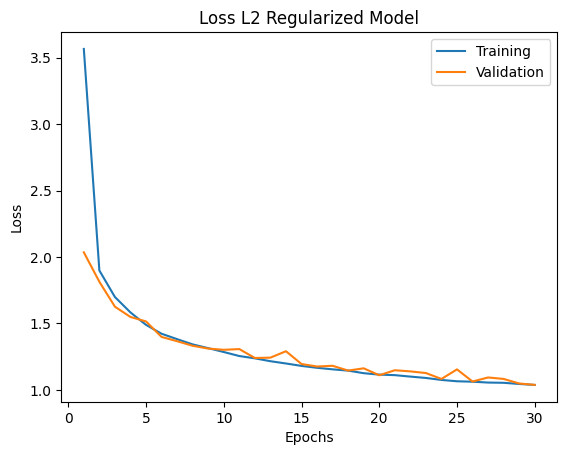

In [43]:
# L2 Regularized Model
plot_accuracy(history_L2_regularized, "Accuracy L2 Regularized Model")
plot_loss(history_L2_regularized, "Loss L2 Regularized Model")

For the L2 Regularized Model, the training accuracy reaches 88.9%, which is lower compared to the Non-regularized Model. 

However, this decrease in training accuracy is expected because L2 regularization helps reduce overfitting by limiting large weight values.

The learning curves reflect **less overfitting** compared to the Non-regularized Model. The training and validation accuracy curves follow each other closely, and both the training and validation losses decrease steadily, indicating that the model generalizes better to new data. 

This suggests that the L2 regularization has successfully helped the model to better learn patterns that generalize across the training and validation sets, rather than just memorizing the training data.

The learning rate also appears appropriate, as the loss curves decrease without much fluctuation.

#### 1.2.1.3 Validate the model and comment the results

In [44]:
# Make predictions on the validation data
y_pred_val_L2_regularized = model_L2_regularized.predict(X_val)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_val_L2_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_val_L2_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_val_L2_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_val_L2_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_val_L2_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the validation accuracy
model_L2_regularized_val_accuracy = accuracy_score(y_val, y_pred_val_L2_regularized)

# Display the result
print("(L2 Regularized Model) Validation accuracy:", model_L2_regularized_val_accuracy)

565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
(L2 Regularized Model) Validation accuracy: 0.8756505370390876


The validation accuracy for the L2 Regularized Model is 87.6%, which is quite close to the training accuracy of 88.9%. This small gap between training and validation accuracy indicates that the model is generalizing well and has less overfitting compared to the Non-regularized Model.

The training and validation learning curves following each other closely further confirm that the model is not overfitting and is able to learn patterns that extend beyond the training data. 

L2 regularization appears to be effective in improving the generalization capability.

### 1.2.3 Dropout Model

For the Dropout Model, we kept the same architecture as the previous models but introduced dropout layers to reduce overfitting. 

Specifically, we added a dropout rate of 0.2 after each hidden layer to randomly set 20% of the neurons to zero during training. This helps the model avoid relying too heavily on particular nodes and encourages it to learn more robust features.

The addition of dropout is expected to help the model generalize better by preventing it from memorizing the training data.

#### 1.2.3.1 Building the network

In [45]:
# Dropout Model
model_dropout_regularized = Sequential()
model_dropout_regularized.add(Input((input_dim,)))
model_dropout_regularized.add(Dense(1024, activation = "relu"))
model_dropout_regularized.add(Dense(512, activation = "relu"))
model_dropout_regularized.add(Dropout(0.2))
model_dropout_regularized.add(Dense(32, activation = "relu"))
model_dropout_regularized.add(Dropout(0.2))
model_dropout_regularized.add(Dense(16, activation = "relu"))
model_dropout_regularized.add(Dropout(0.2))
model_dropout_regularized.add(Dense(n_classes, activation = "softmax"))

# Compile the model
model_dropout_regularized.compile(optimizer=Adam(learning_rate=0.001), 
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Summary of the model
model_dropout_regularized.summary()

# Fit the model
history_dropout_regularized = model_dropout_regularized.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=30, 
    validation_data=(X_val, y_val)
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 1024)           │     1,119,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 50)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,826 (6.34 MB)

 Trainable params: 1,661,826 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.2577 - loss: 2.8594 - val_accuracy: 0.7599 - val_loss: 0.8694
Epoch 2/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6471 - loss: 1.2049 - val_accuracy: 0.8604 - val_loss: 0.5131
Epoch 3/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7546 - loss: 0.8260 - val_accuracy: 0.8957 - val_loss: 0.4007
Epoch 4/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7967 - loss: 0.6721 - val_accuracy: 0.9081 - val_loss: 0.3469
Epoch 5/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.8271 - loss: 0.5655 - val_accuracy: 0.9200 - val_loss: 0.3114
Epoch 6/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8402 - loss: 0.5067 - val_accuracy: 0.9249 - val_loss: 0.2979
Epoch 7/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.8574 - loss: 0.4577 - val_accuracy: 0.9306 - val_loss: 0.2894
Epoch 8/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8732 - loss: 0.4051 - 

In [46]:
# Make predictions on the training data
y_pred_dropout_regularized = model_dropout_regularized.predict(X_train)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_dropout_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_dropout_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_dropout_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_dropout_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_dropout_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the training accuracy
model_dropout_regularized_accuracy = accuracy_score(y_train, y_pred_dropout_regularized)

# Display the result
print("(Dropout Regularized Model) Training accuracy:", model_dropout_regularized_accuracy)

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
(Dropout Regularized Model) Training accuracy: 0.9949063393928209


#### 1.2.3.2 Analyze and comment the training results

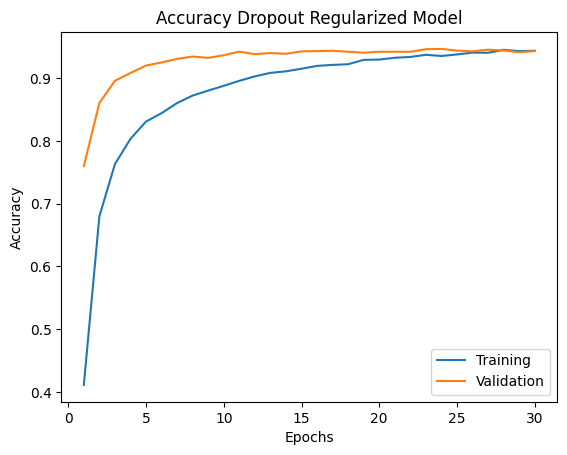

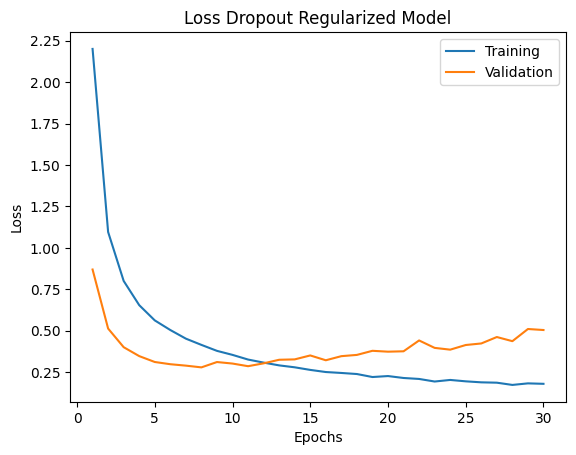

In [47]:
# Dropout Regularized Model
plot_accuracy(history_dropout_regularized, "Accuracy Dropout Regularized Model")
plot_loss(history_dropout_regularized, "Loss Dropout Regularized Model")

For the Dropout Regularized Model, the training accuracy reaches 99.5%, which is high and similar to the Non-regularized Model.

The learning curves show that dropout has **helped reduce overfitting** compared to the Non-regularized version. Although the training accuracy is high, the validation accuracy remains close to the training accuracy throughout the epochs, indicating **better generalization**.

From the loss curves, the training and validation loss decrease steadily, but with some fluctuations for validation loss, which is common with dropout since it randomly deactivates neurons during training.

#### 1.2.1.3 Validate the model and comment the results

Let's calculate the accuracy on the validation set, compare it with the training accuracy and include the previous comments about the generalization capability.

In [48]:
# Make predictions on the validation data
y_pred_val_dropout_regularized = model_dropout_regularized.predict(X_val)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_val_dropout_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_val_dropout_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_val_dropout_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_val_dropout_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_val_dropout_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the validation accuracy
model_dropout_regularized_val_accuracy = accuracy_score(y_val, y_pred_val_dropout_regularized)

# Display the result
print("(Dropout Regularized Model) Validation accuracy:", model_dropout_regularized_val_accuracy)

565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
(Dropout Regularized Model) Validation accuracy: 0.9430849296866349


The validation accuracy for the Dropout Regularized Model is 94.3%, which is slightly lower than the training accuracy of 99.5%.

However, the relatively small gap between training and validation accuracies suggests good generalization. The learning curves also confirm that the model is not overfitting as much as the Non-regularized Model. Dropout seems to have effectively improved the model's ability to generalize to new data, reducing the overfitting while still maintaining a high level of performance.

The Dropout Regularized Model appears to achieve a good balance between fitting the training data and generalizing to unseen examples.

## 1.3. Compare the performances of the two models (non-regularized and regularized) on the provided test set, visualize and comment the results



We saw the test set has a similar distribution with respect to the training set, so we could expect similar metrics for the predictions on the test data.

We've already prepared the test set before, so let's check the performance on it!

### Test set predictions - Non-regularized Model

In [50]:
# Make predictions on the test data
y_pred_test_non_regularized = model_non_regularized.predict(X_test)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_test_non_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_test_non_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_test_non_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_test_non_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_test_non_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the test accuracy
model_non_regularized_test_accuracy = accuracy_score(y_test, y_pred_test_non_regularized)

# Display the result
print("(Non-regularized Model) Test accuracy:", model_non_regularized_test_accuracy)

753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
(Non-regularized Model) Test accuracy: 0.939833077274426


- Validation Accuracy: 93.9%
- Test Accuracy: 93.98%

The test accuracy is very similar to the validation accuracy, which suggests that the model can generalize reasonably well. 

However, as we saw in the learning curves, there was clear overfitting: the training accuracy was much higher than the validation accuracy. 

The learning curve showed a **significant gap** between training and validation accuracies.

### Test set predictions - L1 Regularized Model

In [51]:
# Make predictions on the test data
y_pred_test_L1_regularized = model_L1_regularized.predict(X_test)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_test_L1_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_test_L1_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_test_L1_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_test_L1_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_test_L1_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the test accuracy
model_L1_regularized_test_accuracy = accuracy_score(y_test, y_pred_test_L1_regularized)

# Display the result
print("(L1 Regularized Model) Test accuracy:", model_L1_regularized_test_accuracy)

753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
(L1 Regularized Model) Test accuracy: 0.03637420587136154


- Validation Accuracy: 3.46%
- Test Accuracy: 3.64%

For the L1 Regularized Model, the test accuracy is very close to the validation accuracy, both of which are extremely low. This reinforces what we saw in the learning curves: both training and validation accuracies were very low, and both curves were flat, indicating that the model **failed** to learn useful features from the data. 

### Test set predictions - L2 Regularized Model

In [52]:
# Make predictions on the test data
y_pred_test_L2_regularized = model_L2_regularized.predict(X_test)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_test_L2_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_test_L2_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_test_L2_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_test_L2_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_test_L2_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the test accuracy
model_L2_regularized_test_accuracy = accuracy_score(y_test, y_pred_test_L2_regularized)

# Display the result
print("(L2 Regularized Model) Test accuracy:", model_L2_regularized_test_accuracy)

753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
(L2 Regularized Model) Test accuracy: 0.8741020636963833


- Validation Accuracy: 87.57%
- Test Accuracy: 87.41%

The L2 Regularized Model exhibited similar performance on both validation and test sets, which suggests **good generalization**. In the learning curves, we saw that training and validation accuracies were closely aligned, which is an indication of **reduced overfitting** compared to the Non-regularized Model.

### Test set predictions - Dropout Model

In [53]:
# Make predictions on the test data
y_pred_test_dropout_regularized = model_dropout_regularized.predict(X_test)

# Use argmax (instead of round, to avoid having all 0 in some predictions) for converting to a one-hot encoding format
y_pred_indices = np.argmax(y_pred_test_dropout_regularized, axis=1)
y_pred_one_hot = np.zeros_like(y_pred_test_dropout_regularized)
y_pred_one_hot[np.arange(len(y_pred_indices)), y_pred_indices] = 1
y_pred_test_dropout_regularized = y_pred_one_hot

# Make sure there are no predictions with only zeros
assert np.sum(np.all(y_pred_test_dropout_regularized == 0, axis=1)) == 0, "Some predictions have only zeros"

# Make sure there are no predictions with more than one '1'
assert np.all(np.sum(y_pred_test_dropout_regularized, axis=1) == 1), "Some predictions do not have exactly one '1'"

# Calculate the test accuracy
model_dropout_regularized_test_accuracy = accuracy_score(y_test, y_pred_test_dropout_regularized)

# Display the result
print("(Dropout Regularized Model) Test accuracy:", model_dropout_regularized_test_accuracy)

753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
(Dropout Regularized Model) Test accuracy: 0.9425320765685338


- Validation Accuracy: 94.3%
- Test Accuracy: 94.25%

The Dropout Regularized Model showed almost identical performance on both validation and test sets, with a test accuracy of 94.25% and a validation accuracy of 94.3%. From the learning curves, we saw that training and validation accuracies followed each other closely, suggesting that dropout effectively prevented overfitting (of course it's not perfectly stable as explained before, because of the random neuron deactivations).

### Final considerations

#### Best model

For the best model, the **Dropout** Regularized Model stands out, achieving a test accuracy of 94.25% and a validation accuracy of 94.3%, which are very consistent, showing strong generalization.

From the learning curves, dropout helped minimize overfitting by keeping training and validation metrics closely aligned. **However**, the learning curves for dropout were **less stable**, which is expected due to the random deactivation of neurons during training.

When comparing **training vs test metrics**, **dropout showed high consistency**, which is critical for evaluating model performance on unseen data. Despite some minor instability, dropout was the most effective in balancing good performance with generalization, making it the best model.

#### Deeper analysis on predicted classes

We will perform a deeper analysis to find out how well each class is getting predicted by each model, by calculating the accuracy on each one and then showing the results.

In [106]:
# Convert y_test from one-hot encoded format to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Create sub-dataframes for each class
sub_dfs = {}

# Create sub-dataframes for each class based on one-hot encoded labels
for class_label in range(50):
    class_indices = np.where(y_test[:, class_label] == 1)[0]
    sub_dfs[class_label] = (X_test[class_indices], y_test[class_indices])

In [107]:
# Initialize a dataframe to store the accuracies for each model and class
class_accuracy_df = pd.DataFrame(columns=['Model'] + [f'Class_{i+1}' for i in range(50)])
class_accuracy_df['Model'] = ["Non-Regularized", "L1 Regularized", "L2 Regularized", "Dropout Regularized"]

# Models and their predictions for iteration
models_predictions = {
    "Non-Regularized": y_pred_test_non_regularized,
    "L1 Regularized": y_pred_test_L1_regularized,
    "L2 Regularized": y_pred_test_L2_regularized,
    "Dropout Regularized": y_pred_test_dropout_regularized,
}

In [108]:
# Loop through each model and calculate accuracy for each class
for model_name, y_pred in models_predictions.items():
    accuracies_per_class = []
    for class_label in range(50):
        X_sub, y_sub = sub_dfs[class_label]
        y_pred_sub = y_pred[np.where(y_test[:, class_label] == 1)]
        
        # Calculate accuracy for the class
        class_accuracy = accuracy_score(y_sub, y_pred_sub)

        accuracies_per_class.append(class_accuracy)

    # Find the index for the current model in the DataFrame
    model_index = class_accuracy_df.index[class_accuracy_df['Model'] == model_name].tolist()[0]

    # Assign accuracies for each class using iloc for precise index-based assignment
    class_accuracy_df.iloc[model_index, 1:] = accuracies_per_class

In [109]:
class_accuracy_df

,Model,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14,Class_15,Class_16,Class_17,Class_18,Class_19,Class_20,Class_21,Class_22,Class_23,Class_24,Class_25,Class_26,Class_27,Class_28,Class_29,Class_30,Class_31,Class_32,Class_33,Class_34,Class_35,Class_36,Class_37,Class_38,Class_39,Class_40,Class_41,Class_42,Class_43,Class_44,Class_45,Class_46,Class_47,Class_48,Class_49,Class_50
0,Non-Regularized,0.970037,0.779221,0.938871,0.963018,0.953795,0.973404,0.929699,0.843243,0.926537,0.971466,0.980594,0.927203,0.914634,0.930693,0.972344,0.976032,0.9,0.876923,0.953704,0.971726,0.957143,0.956716,0.884451,0.964539,0.88,0.98494,0.925517,0.90991,0.933426,0.846154,0.949791,0.912879,0.889362,0.951567,0.959055,0.956835,0.861635,0.903346,0.772414,0.938095,0.901316,0.945748,0.83908,0.944444,0.941176,0.972818,0.943368,0.901734,0.921659,0.895425
1,L1 Regularized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,L2 Regularized,0.94382,0.61039,0.857367,0.908284,0.872937,0.925532,0.830703,0.72973,0.872564,0.933852,0.966895,0.873563,0.768293,0.905941,0.924309,0.9747,0.745455,0.661538,0.933862,0.889881,0.861905,0.864179,0.78602,0.794326,0.655,0.900602,0.853793,0.872372,0.846047,0.375,0.895397,0.723485,0.878014,0.917379,0.831496,0.889209,0.773585,0.728625,0.627586,0.890476,0.828947,0.917889,0.735632,0.948949,0.913399,0.935622,0.900149,0.66474,0.864823,0.78268
3,Dropout Regularized,0.980025,0.662338,0.952978,0.965976,0.935644,0.978723,0.938307,0.859459,0.928036,0.972763,0.981735,0.931034,0.890244,0.871287,0.967977,0.973369,0.918182,0.892308,0.978836,0.950893,0.938095,0.914925,0.911555,0.950355,0.87,0.968373,0.958621,0.942943,0.919556,0.721154,0.953975,0.897727,0.951773,0.910256,0.930709,0.92518,0.899371,0.895911,0.786207,0.968254,0.934211,0.950147,0.873563,0.95045,0.954248,0.961373,0.9538,0.890173,0.924731,0.973856


We can see a weird behavior on the L1 Regularized model: all the accuracies are 0% except for the class 11 that is 100%, so let's confirm that it always assigns 11 as the label:

In [ ]:
# Convert L1 Regularized predictions to class labels
y_pred_test_L1_labels = np.argmax(y_pred_test_L1_regularized, axis=1) + 1  # + 1 is used to go back to [1, 50] instead of [0, 49]

# Distribution of the L1 Regularized predictions, without plotting
np.unique(y_pred_test_L1_labels, return_counts=True)

(array([11], dtype=int64), array([24083], dtype=int64))

We confirmed it: why does it happen?

It's simple: **11 is the most frequent label in the training set**, and we saw from the learning curves that **the L1 Regularized Model doesn't learn** at all during the epochs.

Let's analyze the other models: Non-Regularized vs L2 Regularized vs Dropout Regularized.

We'll check the distribution of the accuracies first:

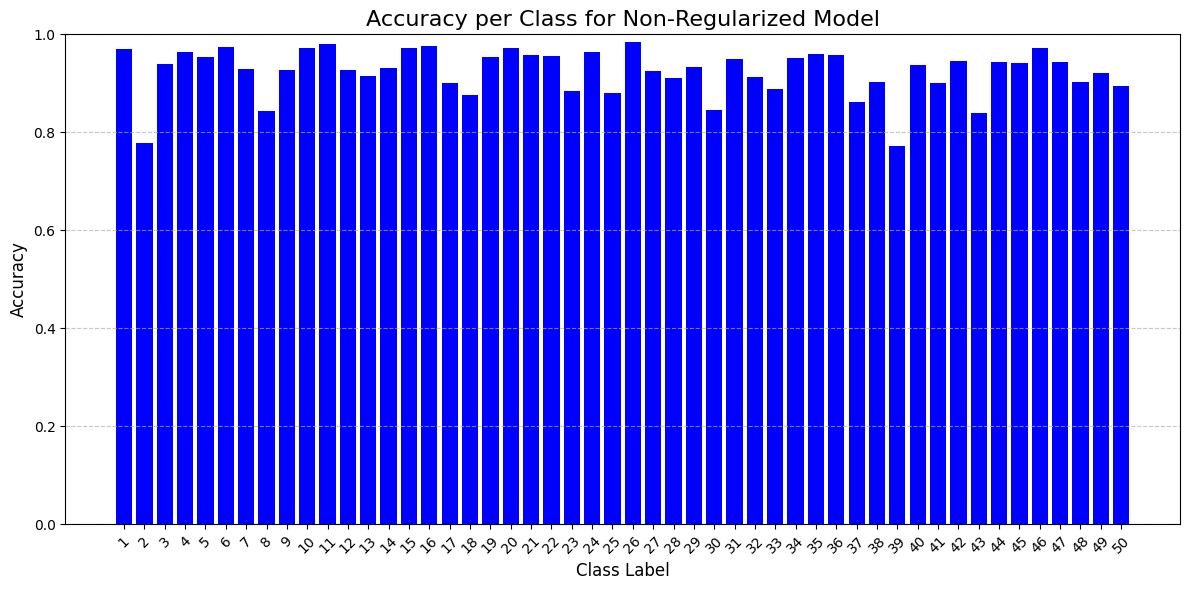

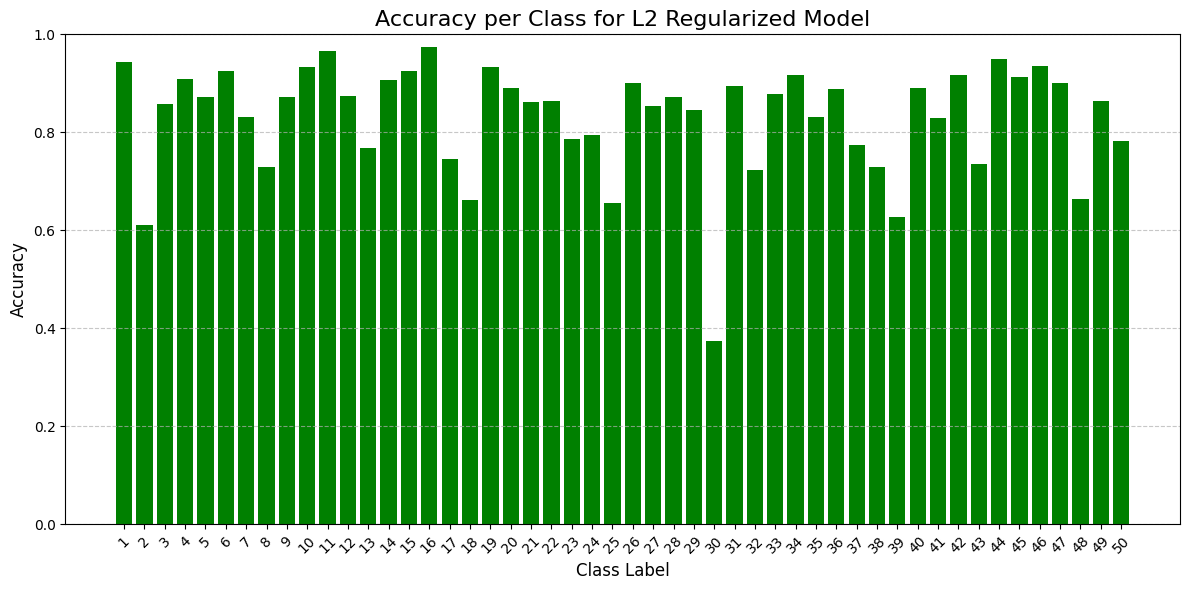

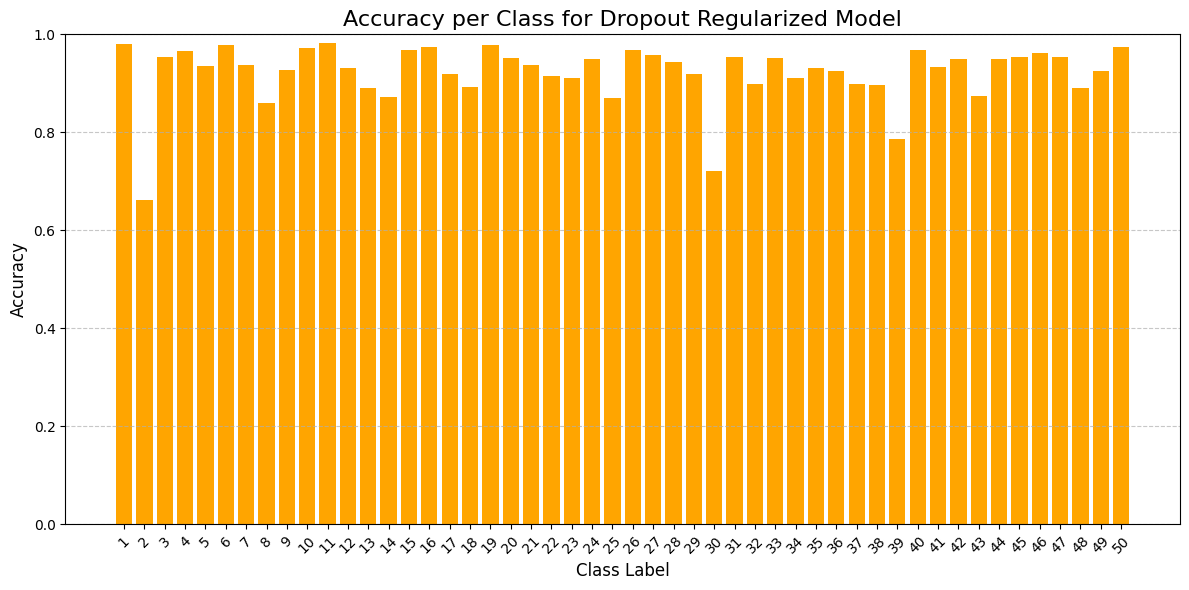

In [117]:
# Models to plot
models_to_plot = ["Non-Regularized", "L2 Regularized", "Dropout Regularized"]
colors = ["blue", "green", "orange"]

# Loop through each model and plot the class-wise accuracy in a separate plot
for model_name, color in zip(models_to_plot, colors):
    class_accuracies = class_accuracy_df[class_accuracy_df['Model'] == model_name].iloc[0, 1:]
    
    # Set figure size
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, 51), class_accuracies, color=color)
    
    # Labels and title
    plt.xlabel('Class Label', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'Accuracy per Class for {model_name} Model', fontsize=16)
    plt.xticks(range(1, 51), rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Let's create a ranking of the top 5 worst classes for each model, but we can already see that e.g. the classes **2** and **30** aren't being predicted very well.

In [120]:
for model_name in models_to_plot:
    # Extract accuracies for the model
    class_accuracies = class_accuracy_df[class_accuracy_df['Model'] == model_name].iloc[0, 1:]
    
    # Sort the accuracies in ascending order and pick the top 5
    worst_accuracies = class_accuracies.sort_values().head(5)
    
    # Print the result
    print(f"Top 5 worst accuracies for {model_name}:")
    for class_label, accuracy in worst_accuracies.items():
        print(f"  {class_label}: {accuracy:.4f}")
    print()

Top 5 worst accuracies for Non-Regularized:
  Class_39: 0.7724
  Class_2: 0.7792
  Class_43: 0.8391
  Class_8: 0.8432
  Class_30: 0.8462

Top 5 worst accuracies for L2 Regularized:
  Class_30: 0.3750
  Class_2: 0.6104
  Class_39: 0.6276
  Class_25: 0.6550
  Class_18: 0.6615

Top 5 worst accuracies for Dropout Regularized:
  Class_2: 0.6623
  Class_30: 0.7212
  Class_39: 0.7862
  Class_8: 0.8595
  Class_25: 0.8700



We can see that in every model the classes **2**, **30**, **39** are one of the worst.

The reason why it happens is probably that, as we saw at the beginning, **in the training set these labels have a small number of samples in the distribution**, so the models don't have a lot of examples to learn from.

# 2. The development of a simple auto-encoder model  [Mandatory]

Let's experiment with a fully connected AutoEncoder model which has a compression factor, between the input size and the smallest encoded representation, in the range of [20-30].

In [30]:
# Function to plot the MSE curve for the AutoEncoder model

def plot_mse(history, title="MSE"):
  x_plot = list(range(1,len(history.history["mse"])+1))
  plt.figure()
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.plot(x_plot, history.history['mse'])
  plt.plot(x_plot, history.history['val_mse'])
  plt.legend(['Training', 'Validation'])

In [31]:
# Compression factor in the range [20-30]
compression_factor = 25

# Calculate the encoding dimension based on the compression factor
encoding_dim = input_dim // compression_factor  # Smallest encoding size

print(f"Input dim: {input_dim}")
print(f"Encoding dim: {encoding_dim}")
print(f"Compression factor: {compression_factor}")

Input dim: 1092
Encoding dim: 43
Compression factor: 25


## 2.1 Building the network

We will use an autoencoder with a compression factor of **25**, meaning that the smallest latent representation is 25 times smaller than the input dimension. 

This fully-connected architecture consists of an input layer of size 1092, followed by downsampling layers with 512 and 128 units, leading to a **latent layer of 43 units**. 

The latent space represents a compressed version of the input data. 

The upsampling layers reverse this compression, expanding back up to the original input size. 

The output layer of the autoencoder uses a **sigmoid** activation function, which outputs values between 0 and 1. This makes it suitable for reconstructing normalized inputs. 

We use **Binary Cross-Entropy** as the loss function because it works well with the sigmoid outputs and measures the reconstruction error effectively.

Additionally, mean squared error (**MSE**) is used as a metric to provide a measure of reconstruction quality in terms of numerical similarity; MSE **penalizes larger errors more heavily**.

This compression and reconstruction aims to capture the most important features of the input data.

In [32]:
# Input layer
input_layer = Input(shape=(input_dim,))

# Downsampling layers
downsampling_hidden_1 = Dense(512, activation="relu", name="downsampling_hidden_1")(input_layer)
downsampling_hidden_2 = Dense(128, activation="relu", name="downsampling_hidden_2")(downsampling_hidden_1)

# Latent layer (encoding)
encoded = Dense(encoding_dim, activation="relu", name="latent")(downsampling_hidden_2)

# Upsampling layers
upsampling_hidden_1 = Dense(128, activation="relu", name="upsampling_hidden_1")(encoded)
upsampling_hidden_2 = Dense(512, activation="relu", name="upsampling_hidden_2")(upsampling_hidden_1)

# Output layer (decoded representation)
decoded = Dense(input_dim, activation='sigmoid', name="decoder")(upsampling_hidden_2)

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), 
                    loss='binary_crossentropy', 
                    metrics = ["mse"])

# Summary of the model
autoencoder.summary()

# Fit the model
autoencoder_history = autoencoder.fit(X_train, X_train,
                                  epochs=100,
                                  batch_size=1024,
                                  shuffle=True,
                                  validation_data=(X_val, X_val))

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1092)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_1 (Dense)   │ (None, 512)            │       559,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_2 (Dense)   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 43)             │         5,547 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_1 (Dense)     │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_2 (Dense)     │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 1092)           │       560,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,262,703 (4.82 MB)

 Trainable params: 1,262,703 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.4825 - mse: 0.1302 - val_loss: 0.3453 - val_mse: 0.0811
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.3272 - mse: 0.0749 - val_loss: 0.2823 - val_mse: 0.0596
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.2715 - mse: 0.0557 - val_loss: 0.2477 - val_mse: 0.0474
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2427 - mse: 0.0456 - val_loss: 0.2295 - val_mse: 0.0411
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.2264 - mse: 0.0400 - val_loss: 0.2177 - val_mse: 0.0370
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.2152 - mse: 0.0361 - val_loss: 0.2137 - val_mse: 0.0355
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.2082 - mse: 0.0337 - val_loss: 0.2033 - val_mse: 0.0321
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2017 - mse: 0.0315 - val_loss: 0.1977 - val_mse: 0.0302
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - lo

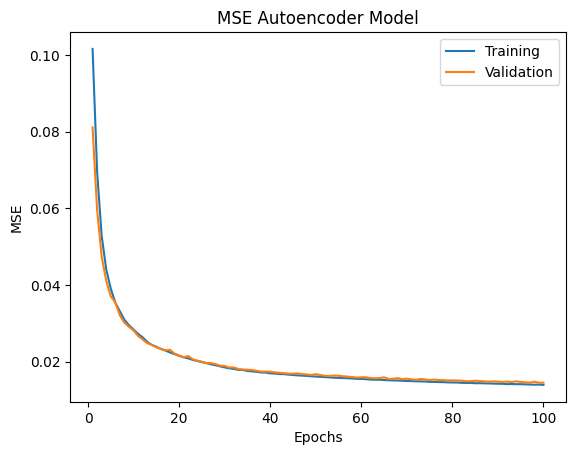

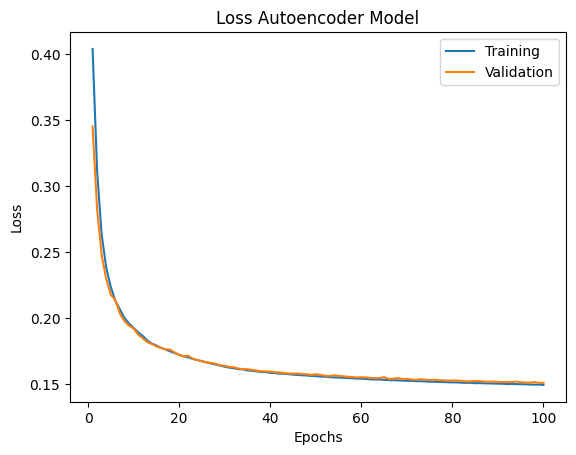

In [33]:
# Autoencoder learning curves
plot_mse(autoencoder_history, "MSE Autoencoder Model")
plot_loss(autoencoder_history, "Loss Autoencoder Model")

The learning curves for both MSE and Binary Cross-Entropy loss steadily decrease over 100 epochs, with minimal fluctuations, indicating a good fit without overfitting. The training and validation metrics stay closely aligned, showing effective minimization of reconstruction errors.

As said before, Binary Cross-Entropy measures how well the model reconstructs each feature probabilistically, suitable for the sigmoid output, while MSE captures the squared differences, penalizing larger errors more. 

Both metrics show a smooth decline, suggesting that the model reconstructs key features successfully without overfitting.

Now let's create two pointers, which are the encoder and the decoder sub-models of the autoencoder model:

In [34]:
# Encoder model (pointer to the autoencoder main model)
encoder_model = Model(input_layer, encoded)
encoder_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1092)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_1 (Dense)   │ (None, 512)            │       559,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsampling_hidden_2 (Dense)   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,827 (2.41 MB)

 Trainable params: 630,827 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Decoder model (pointer to the autoencoder main model)
decoder_model = Model(encoded, decoded)
decoder_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_10CLONE            │ (None, 43)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_1 (Dense)     │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_hidden_2 (Dense)     │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 1092)           │       560,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 631,876 (2.41 MB)

 Trainable params: 631,876 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

These pointers will be very useful later.

## 2.2 Visually Inspecting the results

We will now encode and decode the test set images and visualize the results: 

753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


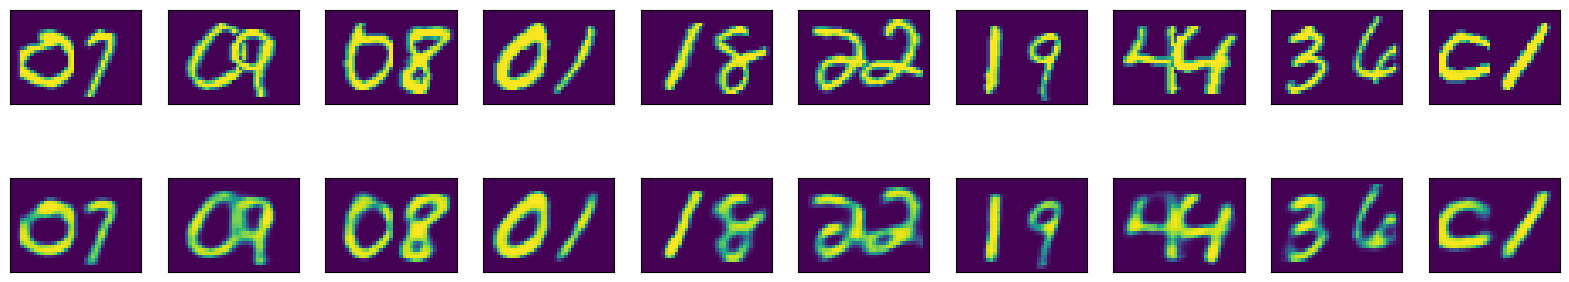

In [36]:
# Encode
encoded_test_imgs = encoder_model.predict(X_test)

# Decode
decoded_test_imgs = decoder_model.predict(encoded_test_imgs)

# Show the result for the first 10 images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Show the original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 39))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Show the reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test_imgs[i].reshape(28, 39))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The visual reconstruction results show that the autoencoder performs reasonably well in capturing the core information of the input data. 

Although there is some blurring in the reconstructed samples, the important features are still preserved, making the digits recognizable. 

This slight loss of detail is expected due to the compression applied in the latent space. 

We can say the reconstructions are fairly close to the original images, suggesting that the autoencoder has learned useful features of the dataset. Let's calculate the test metrics MAE and MSE:

In [37]:
# Autoencoder's test predictions 
autoencoder_test_pred = autoencoder.predict(X_test)

# Calculate and show MAE and MSE
print(f"Autoencoder's MAE: {mean_absolute_error(X_test, autoencoder_test_pred)}")
print(f"Autoencoder's MSE: {mean_squared_error(X_test, autoencoder_test_pred)}")

753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Autoencoder's MAE: 0.05088623888517201
Autoencoder's MSE: 0.014523365805807554


The MAE and MSE indicate that the autoencoder is generally reconstructing the inputs well, with small average errors. 

The low values for both metrics suggest effective performance, but there is some blurriness in reconstructions, as seen visually.

## 2.3 Generate new samples

Now, we explore the generative abilities of the trained autoencoder model by generating new samples from random latent encodings.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


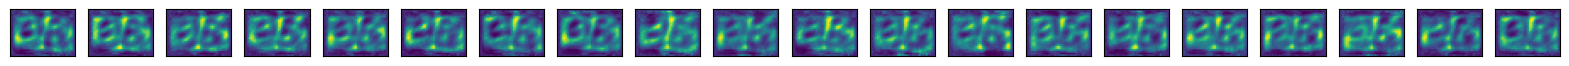

In [38]:
# Number of new samples to generate
n = 20

# Generate n random latent encodings of size equal to the encoding dimension
random_encodings = np.random.rand(n, encoding_dim)

# Decode these latent encodings into the original space
decoded_imgs = decoder_model.predict(random_encodings)

# Plot the generated samples
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 39))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The generated new samples from random latent encodings show blurry visuals, which do not clearly represent specific digits or details. 

This is a common outcome when generating samples from a randomly sampled latent space, as these encodings might not correspond to meaningful representations.

The generated images are mostly unrecognizable and represent **some vague digit-like shapes**. This suggests that the model has captured certain aspects of the data distribution but struggles to produce distinguishable outputs.

More sophisticated approaches may be needed to generate clearer and more meaningful samples from latent spaces.

# 3.A [OPTIONAL] The use and evaluation of the latent (encoded) representations generated by the auto-encoder to solve the problem of supervised classification.

In this section, we use the latent representations from the autoencoder for supervised classification. 

In detail, we:
- extract encoded versions of X_train, X_val, and X_test
- train an XGBoost model on the encoded data
- train the same model on the original data and also with PCA
- compare all models in terms of accuracy, overfitting, and efficiency


In [ ]:
# Function to plot mlogloss and 1-merror (accuracy) of a given XGBoost model

def plot_learning_curves_xgb(xgb_model, title_loss="Loss XGBoost", title_accuracy="Accuracy XGBoost"):
    # Retrieve training and validation metrics
    evals_result = xgb_model.evals_result()

    # Extract epochs and corresponding metrics
    epochs = range(1, len(evals_result['validation_0']['mlogloss']) + 1)

    # Extract loss and merror for training and validation
    train_loss = evals_result['validation_0']['mlogloss']
    val_loss = evals_result['validation_1']['mlogloss']

    train_error = evals_result['validation_0']['merror']
    val_error = evals_result['validation_1']['merror']

    # Calculate accuracy as 1 - merror
    train_accuracy = [1 - error for error in train_error]
    val_accuracy = [1 - error for error in val_error]

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training (1 - merror)')
    plt.plot(epochs, val_accuracy, label='Validation (1 - merror)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title_accuracy)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training (mlogloss)')
    plt.plot(epochs, val_loss, label='Validation (mlogloss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title_loss)
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [ ]:
# Convert one-hot encoded labels to integer labels, in range [0, 49], needed for XGBoost
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

## Latent representations of the dataset (X_train_encoded, X_val_encoded and X_test_encoded)

Let's obtain X_train_encoded, X_val_encoded and X_test_encoded, which are respectively the encoded representations of X_train, X_val and X_test generated by the encoder sub-model implemented in task 2.

In [ ]:
# Obtain encoded representations using the encoder sub-model
X_train_encoded = encoder_model.predict(X_train)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test)

print("Shape of X_train_encoded:", X_train_encoded.shape)
print("Shape of X_val_encoded:", X_val_encoded.shape)
print("Shape of X_test_encoded:", X_test_encoded.shape)

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of X_train_encoded: (54185, 43)
Shape of X_val_encoded: (18062, 43)
Shape of X_test_encoded: (24083, 43)


## Machine Learning model to classify the dataset in the latent space

We use XGBoost for our classification due to its ensemble nature, which combines many smaller models (decision trees) to form a powerful model. This helps capture complex patterns in the data effectively, making it a suitable choice here.

We chose n_estimators=100 to control the number of boosting rounds, achieving a balance between training time and accuracy, while learning_rate=0.1 helps ensure that the model gradually learns without large fluctuations.

We set max_depth=5 to prevent overfitting and maintain model simplicity. 

The objective is set to "multi:softmax" for multi-class classification, suitable for our problem with 50 classes (num_class=50).

For evaluation, we use "mlogloss" (**multi-class logarithmic loss**) to evaluate how well the predicted probabilities match the true labels. It works like categorical cross-entropy in neural networks to help the model learn by showing how confident or wrong it is about its predictions. **"merror"** measures the number of incorrect predictions, letting us calculate accuracy as 1 - merror. 

Using both gives us a way to track both how good the probability estimates are (mlogloss) and the actual classification performance (merror).

In [65]:
# Define XGBoost classifier for encoded data
xgb_classifier_encoded = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective="multi:softmax",
    num_class=n_classes,  # 50
    use_label_encoder=False,
    eval_metric=["mlogloss", "merror"],
    random_state=42
)

In [66]:
# Train on the encoded representation with validation
xgb_classifier_encoded.fit(
    X_train_encoded,
    y_train_int,
    eval_set=[(X_train_encoded, y_train_int), (X_val_encoded, y_val_int)],
    verbose=True
)

[0]	validation_0-mlogloss:3.33537	validation_0-merror:0.53371	validation_1-mlogloss:3.40419	validation_1-merror:0.59927
[1]	validation_0-mlogloss:3.05198	validation_0-merror:0.47116	validation_1-mlogloss:3.15474	validation_1-merror:0.54662
[2]	validation_0-mlogloss:2.84196	validation_0-merror:0.43481	validation_1-mlogloss:2.96897	validation_1-merror:0.51606
[3]	validation_0-mlogloss:2.67156	validation_0-merror:0.40723	validation_1-mlogloss:2.82040	validation_1-merror:0.49540
[4]	validation_0-mlogloss:2.52760	validation_0-merror:0.38573	validation_1-mlogloss:2.69509	validation_1-merror:0.47968
[5]	validation_0-mlogloss:2.40227	validation_0-merror:0.36833	validation_1-mlogloss:2.58627	validation_1-merror:0.46900
[6]	validation_0-mlogloss:2.29221	validation_0-merror:0.35550	validation_1-mlogloss:2.49033	validation_1-merror:0.45859
[7]	validation_0-mlogloss:2.19156	validation_0-merror:0.34355	validation_1-mlogloss:2.40245	validation_1-merror:0.44746
[8]	validation_0-mlogloss:2.10199	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=50, num_parallel_tree=None, ...)

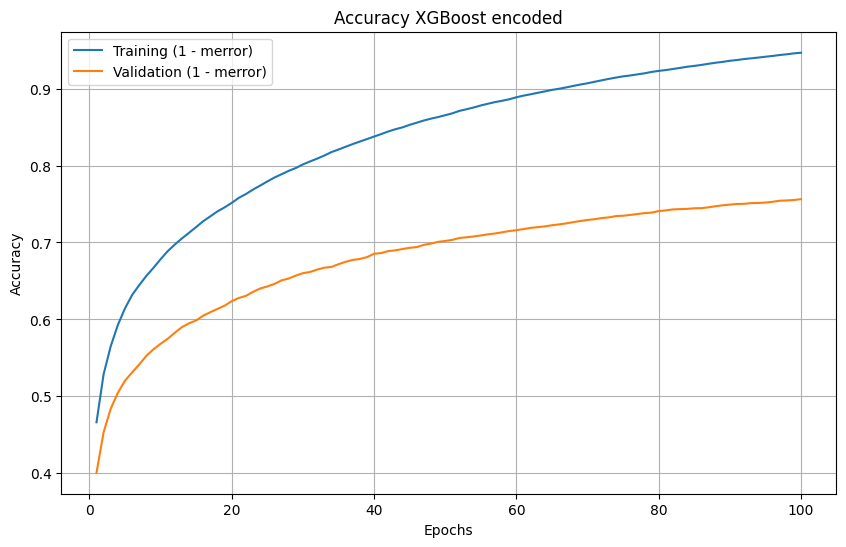

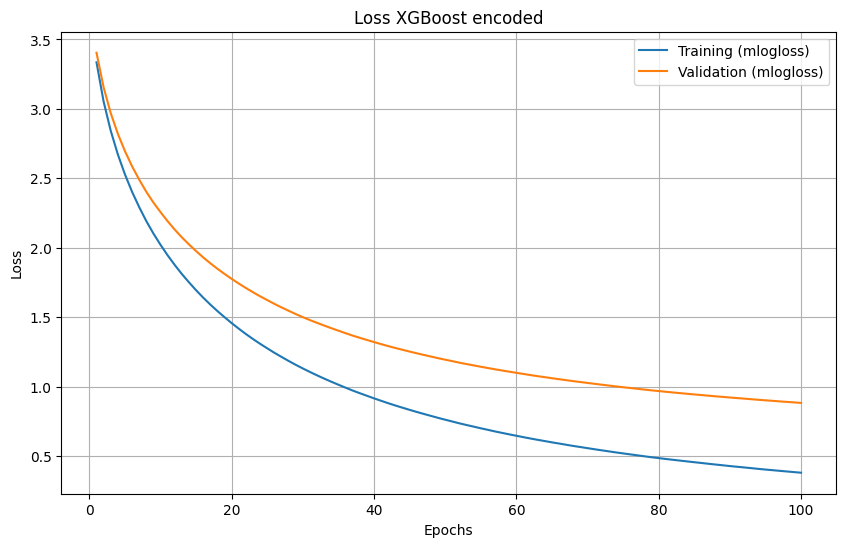

In [130]:
# XGBoost Encoded
plot_learning_curves_xgb(xgb_classifier_encoded, "Loss XGBoost encoded", "Accuracy XGBoost encoded")

In [73]:
# Make predictions on training, validation, and test data
xgb_encoded_train_pred = xgb_classifier_encoded.predict(X_train_encoded)
xgb_encoded_val_pred = xgb_classifier_encoded.predict(X_val_encoded)
xgb_encoded_test_pred = xgb_classifier_encoded.predict(X_test_encoded)

# Calculate accuracy for training data, validation data and test data
xgb_encoded_train_accuracy = accuracy_score(y_train_int, xgb_encoded_train_pred)
xgb_encoded_val_accuracy = accuracy_score(y_val_int, xgb_encoded_val_pred)
xgb_encoded_test_accuracy = accuracy_score(y_test_int, xgb_encoded_test_pred)

print("(XGBoost encoded) Training accuracy:", xgb_encoded_train_accuracy)
print("(XGBoost encoded) Validation accuracy:", xgb_encoded_val_accuracy)
print("(XGBoost encoded) Test accuracy:", xgb_encoded_test_accuracy)

(XGBoost encoded) Training accuracy: 0.9465903847928393
(XGBoost encoded) Validation accuracy: 0.7562839109733142
(XGBoost encoded) Test accuracy: 0.7597475397583358


The learning curves for the encoded XGBoost model show **clear overfitting**. 

Training accuracy reaches 95%, while validation accuracy lags at around **76%**, indicating poor generalization.

Similarly, training loss drops steadily, but validation loss remains much higher, highlighting the model's difficulty in applying learned patterns to unseen data. 

The encoded features help **reduce training time**.

## Machine Learning model to classify the dataset in the original space

We train an XGBoost classifier on the original dataset without any dimensionality reduction or feature extraction. 

This allows us to compare the model's performance and overfitting tendencies directly with the encoded version (and later PCA too). 

Training on the original high-dimensional input provides the highest level of detail, but also involves significantly higher computational cost and training time.

In [115]:
# Define XGBoost classifier for original data
xgb_classifier_original = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective="multi:softmax",
    num_class=n_classes,  # 50
    use_label_encoder=False,
    eval_metric=["mlogloss", "merror"],
    random_state=42
)

In [116]:
# Train on the original representation with validation
xgb_classifier_original.fit(
    X_train,
    y_train_int,
    eval_set=[(X_train, y_train_int), (X_val, y_val_int)],
    verbose=True
)

[0]	validation_0-mlogloss:3.08158	validation_0-merror:0.40845	validation_1-mlogloss:3.13337	validation_1-merror:0.45084
[1]	validation_0-mlogloss:2.75289	validation_0-merror:0.34236	validation_1-mlogloss:2.83168	validation_1-merror:0.39209
[2]	validation_0-mlogloss:2.51574	validation_0-merror:0.30981	validation_1-mlogloss:2.61499	validation_1-merror:0.36519
[3]	validation_0-mlogloss:2.32502	validation_0-merror:0.28628	validation_1-mlogloss:2.43996	validation_1-merror:0.34575
[4]	validation_0-mlogloss:2.16960	validation_0-merror:0.26889	validation_1-mlogloss:2.29852	validation_1-merror:0.33047
[5]	validation_0-mlogloss:2.03447	validation_0-merror:0.25457	validation_1-mlogloss:2.17552	validation_1-merror:0.32051
[6]	validation_0-mlogloss:1.91538	validation_0-merror:0.24230	validation_1-mlogloss:2.06868	validation_1-merror:0.30838
[7]	validation_0-mlogloss:1.81012	validation_0-merror:0.23148	validation_1-mlogloss:1.97377	validation_1-merror:0.30202
[8]	validation_0-mlogloss:1.71574	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=50, num_parallel_tree=None, ...)

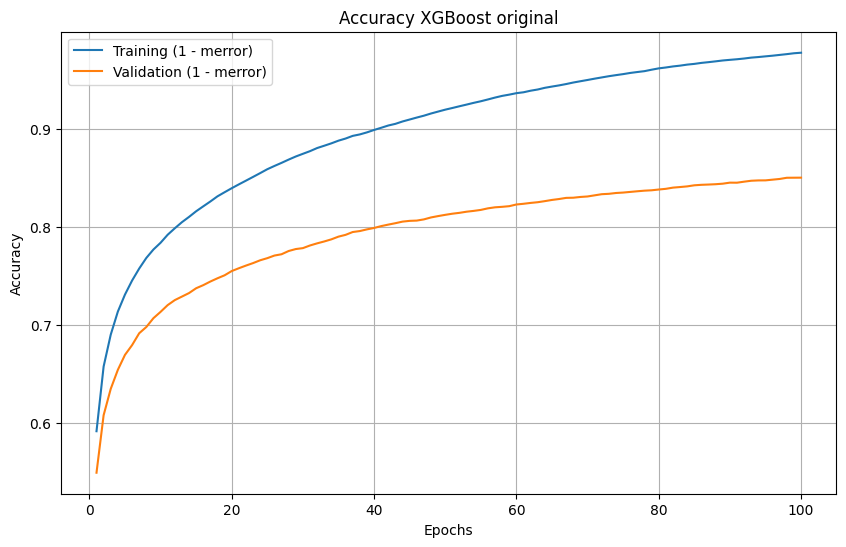

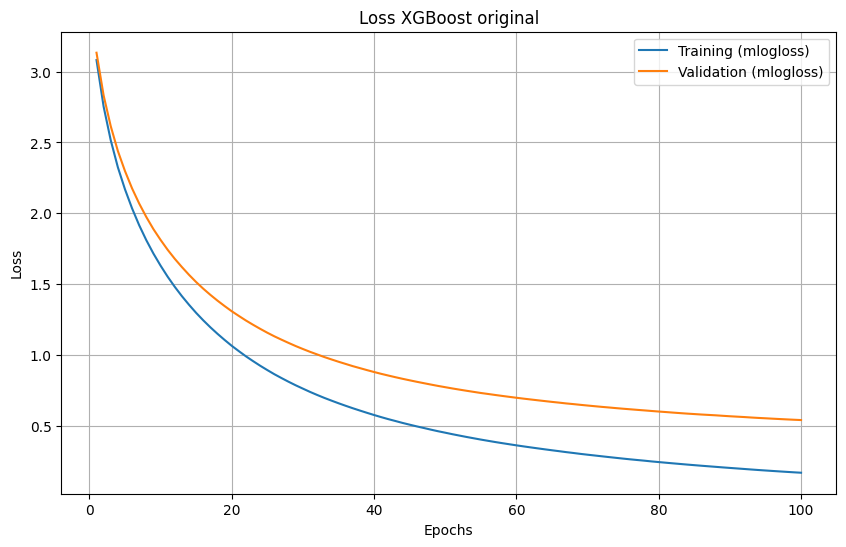

In [132]:
# XGBoost original
plot_learning_curves_xgb(xgb_classifier_original, "Loss XGBoost original", "Accuracy XGBoost original")

In [120]:
# Make predictions on training, validation, and test data
xgb_original_train_pred = xgb_classifier_original.predict(X_train)
xgb_original_val_pred = xgb_classifier_original.predict(X_val)
xgb_original_test_pred = xgb_classifier_original.predict(X_test)

# Calculate accuracy for training data, validation data and test data
xgb_original_train_accuracy = accuracy_score(y_train_int, xgb_original_train_pred)
xgb_original_val_accuracy = accuracy_score(y_val_int, xgb_original_val_pred)
xgb_original_test_accuracy = accuracy_score(y_test_int, xgb_original_test_pred)

print("(XGBoost original) Training accuracy:", xgb_original_train_accuracy)
print("(XGBoost original) Validation accuracy:", xgb_original_val_accuracy)
print("(XGBoost original) Test accuracy:", xgb_original_test_accuracy)

(XGBoost original) Training accuracy: 0.9781120236227738
(XGBoost original) Validation accuracy: 0.8505148931458311
(XGBoost original) Test accuracy: 0.8533820537308475


The learning curves for the model trained on the original data show a **better performance** compared to the encoded data version. 

Training accuracy increases steadily, while validation accuracy also improves, though more slowly. The final training accuracy is notably higher, indicating some overfitting, but the validation accuracy is higher compared to the encoded version, with a smaller gap between training and validation.

Metrics confirm this: training accuracy of 97.8% versus validation accuracy of 85.0% shows **some overfitting**, but the model performs best, achieving a test accuracy of 85.3%. 

This performance, **however**, comes with a trade-off: **training took around 21 minutes**, compared to **only ~30 seconds for the other models** (as we will see, with PCA data too).

## Machine Learning model to classify the dataset in the PCA space

We also use PCA because of the high-dimensionality of the data, and we noticed that XGBoost takes a long time to train without preprocessing. PCA helps reduce dimensionality and allows for comparison with the encoded representation from the Autoencoder.

We retain 70% of the variance, resulting in 43 components, matching the latent space dimension of the Autoencoder. 

This helps provide a fair comparison between models trained on PCA data and those trained on encoded data.

In [ ]:
# PCA with 70% variance explained
pca = PCA(n_components=0.7)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Check how many components were chosen
n_components = X_train_pca.shape[1]
print(f"Number of components chosen: {n_components}")

Number of components chosen: 43


In [123]:
# Define XGBoost classifier for PCA data
xgb_classifier_pca = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective="multi:softmax",
    num_class=n_classes,  # 50
    use_label_encoder=False,
    eval_metric=["mlogloss", "merror"],
    random_state=42
)

In [124]:
# Train on the PCA representation with validation
xgb_classifier_pca.fit(
    X_train_pca,
    y_train_int,
    eval_set=[(X_train_pca, y_train_int), (X_val_pca, y_val_int)],
    verbose=True
)

[0]	validation_0-mlogloss:3.21480	validation_0-merror:0.48107	validation_1-mlogloss:3.27554	validation_1-merror:0.53449
[1]	validation_0-mlogloss:2.92592	validation_0-merror:0.43342	validation_1-mlogloss:3.01585	validation_1-merror:0.49352
[2]	validation_0-mlogloss:2.71360	validation_0-merror:0.40550	validation_1-mlogloss:2.82513	validation_1-merror:0.47182
[3]	validation_0-mlogloss:2.54340	validation_0-merror:0.38588	validation_1-mlogloss:2.67136	validation_1-merror:0.45543
[4]	validation_0-mlogloss:2.40187	validation_0-merror:0.37184	validation_1-mlogloss:2.54478	validation_1-merror:0.44386
[5]	validation_0-mlogloss:2.28078	validation_0-merror:0.35986	validation_1-mlogloss:2.43740	validation_1-merror:0.43428
[6]	validation_0-mlogloss:2.17303	validation_0-merror:0.34988	validation_1-mlogloss:2.34185	validation_1-merror:0.42548
[7]	validation_0-mlogloss:2.07676	validation_0-merror:0.33902	validation_1-mlogloss:2.25727	validation_1-merror:0.41806
[8]	validation_0-mlogloss:1.99064	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=50, num_parallel_tree=None, ...)

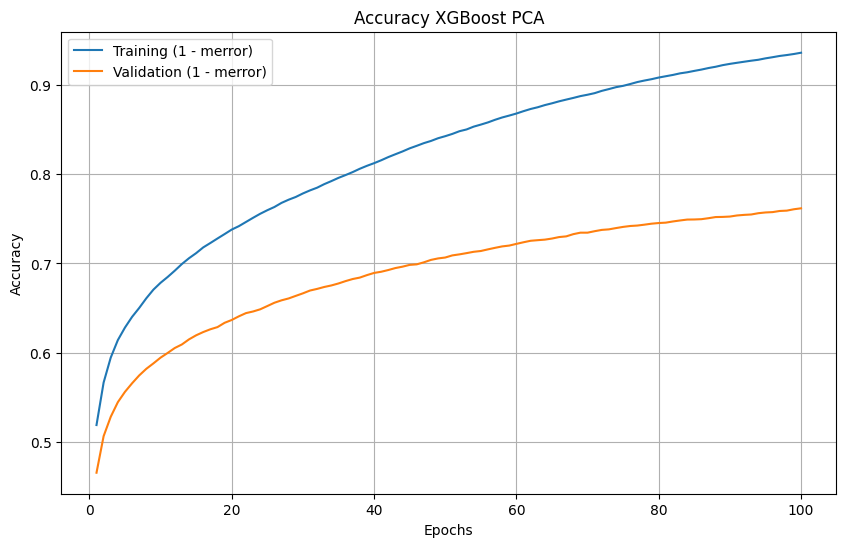

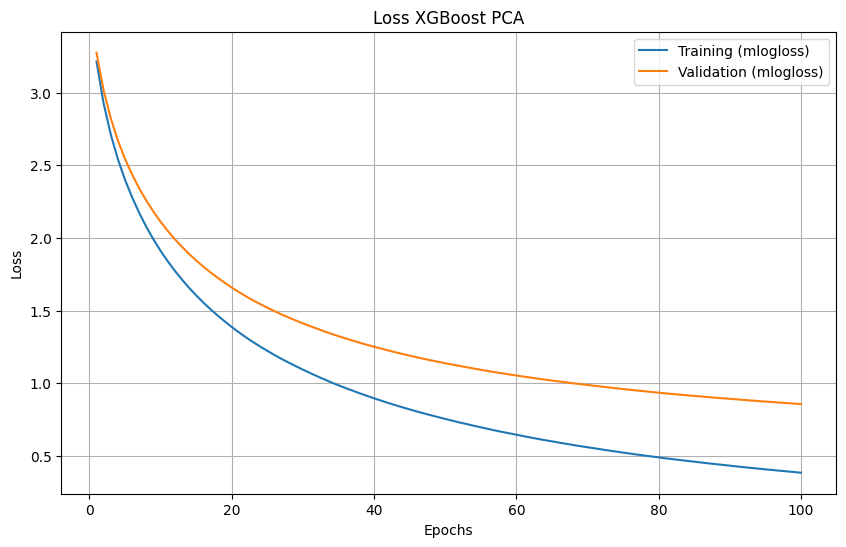

In [133]:
# XGBoost PCA
plot_learning_curves_xgb(xgb_classifier_pca, "Loss XGBoost PCA", "Accuracy XGBoost PCA")

In [126]:
# Make predictions on training, validation, and test data
xgb_pca_train_pred = xgb_classifier_pca.predict(X_train_pca)
xgb_pca_val_pred = xgb_classifier_pca.predict(X_val_pca)
xgb_pca_test_pred = xgb_classifier_pca.predict(X_test_pca)

# Calculate accuracy for training data, validation data and test data
xgb_pca_train_accuracy = accuracy_score(y_train_int, xgb_pca_train_pred)
xgb_pca_val_accuracy = accuracy_score(y_val_int, xgb_pca_val_pred)
xgb_pca_test_accuracy = accuracy_score(y_test_int, xgb_pca_test_pred)

print("(XGBoost PCA) Training accuracy:", xgb_pca_train_accuracy)
print("(XGBoost PCA) Validation accuracy:", xgb_pca_val_accuracy)
print("(XGBoost PCA) Test accuracy:", xgb_pca_test_accuracy)

(XGBoost PCA) Training accuracy: 0.9360893236135461
(XGBoost PCA) Validation accuracy: 0.761765031557967
(XGBoost PCA) Test accuracy: 0.7614499854669269


The learning curves for the XGBoost model trained on PCA data show similar trends to the encoded data model. The training accuracy reaches 93.6%, while the validation accuracy stabilizes at 76.2%, indicating **overfitting**.

The training loss consistently drops, but the validation loss remains higher, reflecting generalization issues. 

PCA results in **comparable performance to the encoded model**, with **faster training than using the original data but** some **accuracy loss**.

## Final considerations: Dropout Model (best model in task 1) vs XGBoost encoded vs XGBoost original vs XGBoost PCA 

In [ ]:
# Accuracy metrics for each model
data = {
    'Model': ['Dropout Model (Task 1)', 'XGBoost Encoded', 'XGBoost Original', 'XGBoost PCA'],
    'Training Accuracy': [model_dropout_regularized_accuracy,
                          xgb_encoded_train_accuracy,
                          xgb_original_train_accuracy,
                          xgb_pca_train_accuracy],
    'Validation Accuracy': [model_dropout_regularized_val_accuracy,
                            xgb_encoded_val_accuracy,
                            xgb_original_val_accuracy,
                            xgb_pca_val_accuracy],
    'Test Accuracy': [model_dropout_regularized_test_accuracy,
                      xgb_encoded_test_accuracy,
                      xgb_original_test_accuracy,
                      xgb_pca_test_accuracy]
}

# Create DataFrame
pd.DataFrame(data)

,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,Dropout Model (Task 1),0.994906,0.943085,0.942532
1,XGBoost Encoded,0.946590,0.756284,0.759748
2,XGBoost Original,0.978112,0.850515,0.853382
3,XGBoost PCA,0.936089,0.761765,0.761450


The **Dropout** Regularized Model stands out as the **best performer**, achieving a training accuracy of 99.5%, a validation accuracy of 94.3%, and a test accuracy of 94.25%. The learning curves indicate that **dropout helped mitigate overfitting**, as training and validation metrics stayed closely aligned throughout. The test accuracy being close to the training and validation accuracies demonstrates strong generalization. Despite the learning curves showing some instability due to dropout, the model still achieved the **highest consistency across training, validation, and test sets**.

The **XGBoost Original Model** comes in second, with a training accuracy of 97.8%, validation accuracy of 85.05%, and test accuracy of 85.34%. While this model also demonstrated relatively strong generalization, it exhibited **notable overfitting**, as evidenced by the significant gap between training and validation accuracies. Additionally, the **training time** for this model was **around 21 minute**s, highlighting a significant computational problem compared to the others.

The **XGBoost PCA Model and XGBoost Encoded Model performed similarly**, with both achieving training accuracies around 93-94% and validation accuracies near 76%. The use of PCA or encoded latent representations led to **significant reductions in training time**: approximately **30 seconds** for each, compared to the much longer time needed for the original dataset. While the **accuracies were about 10% lower** than that of the Dropout Regularized and Original Models, the **reduced computational cost** may be a worth trade-off.

To summarize:
- the Dropout Regularized Model provides the best balance between performance and generalization, demonstrating strong accuracy across all datasets with less overfitting
- the XGBoost Original Model also performed well but suffered from overfitting and high training time
- the XGBoost Encoded and PCA Models are valuable for their computational efficiency, despite lower overall accuracies.